In [149]:
import pandas as pd
import numpy as np
from collections import Counter
import hashlib

In [2]:
fin = open('data_train.csv')

featname = fin.readline().strip().split(',')
#Load the maximum index
maxID = {}
finID = open('maxID.txt')
for line in finID:
    i,id = line.strip().split('\t')
    maxID[featname[int(i)]] = int(id) + 1
maxID

{'adnw_id': 36,
 'adspot_id': 1106,
 'advertiser_id': 2166,
 'campaign_id': 11803,
 'category_id': 7204,
 'frequency': 10,
 'game_feed_id': 33598,
 'is_app': 2,
 'last_login_interval': 2349757,
 'last_paid_interval': 1053268596,
 'logged_at': 1,
 'media_id': 89765,
 'uid': 3691112,
 'user_type_id': 5}

In [3]:
train = pd.read_csv("data_train.csv")
train

,logged_at,advertiser_id,campaign_id,category_id,adnw_id,adspot_id,uid,frequency,user_type_id,media_id,is_app,last_login_interval,last_paid_interval,game_feed_id,click
0,2018-03-15 00:00:00.125,1909,7942,0,10,1087,0,3,1,0,1,5018.0,NaN,26118,0
1,2018-03-15 00:00:06.991,1909,7948,0,8,1023,20,5,2,20,1,26361.0,NaN,26122,0
2,2018-03-15 00:00:13.584,1898,7856,0,20,1056,40,7,2,36,1,1963.0,NaN,33487,0
3,2018-03-15 00:00:18.50,1999,9827,0,10,1030,60,0,2,51,1,181157.0,242672.0,30427,0
4,2018-03-15 00:00:22.753,1935,11138,0,10,1030,80,6,2,40,1,22636.0,56118.0,30139,0
5,2018-03-15 00:00:27.552,1930,11382,0,10,1030,100,9,1,52,1,1539.0,NaN,33261,0
6,2018-03-15 00:00:29.917,2088,10668,0,4,1007,109,7,1,83,0,22507.0,NaN,33071,1
7,2018-03-15 00:00:32.027,1637,8632,0,10,1059,120,1,1,3,1,534.0,105530.0,17065,0
8,2018-03-15 00:00:37.89,1867,7628,0,10,1030,140,0,2,103,1,1178669.0,NaN,27234,0
9,2018-03-15 00:00:44.301,2133,11471,0,4,1007,160,3,1,118,1,NaN,NaN,32618,0


In [4]:
test = pd.read_csv("data_test.csv")
test

,logged_at,advertiser_id,campaign_id,category_id,adnw_id,adspot_id,uid,frequency,user_type_id,media_id,is_app,last_login_interval,last_paid_interval,game_feed_id,click
0,2018-03-15 15:28:09.221,1953,8687,0,9,1024,125064,0,2,3851,0,17472.0,281915.0,27380,NaN
1,2018-03-15 15:28:13.202,1909,7948,0,20,1056,3047947,4,2,6921,1,3061.0,NaN,26122,NaN
2,2018-03-15 15:28:17.186,1516,5744,0,10,1030,3201035,6,2,647,1,590649.0,NaN,18928,NaN
3,2018-03-15 15:28:24.852,1270,4294,4424,8,1021,3145374,3,1,789,1,5308.0,NaN,32536,NaN
4,2018-03-15 15:28:31.411,1471,6958,0,10,1030,2251899,0,1,242,1,11124.0,NaN,32659,NaN
5,2018-03-15 15:28:37.108,1972,9254,0,4,1007,3106516,3,1,67,1,288.0,NaN,23243,NaN
6,2018-03-15 15:28:43.701,1270,4293,4425,10,1030,1760031,8,1,8573,1,5114.0,184490.0,33007,NaN
7,2018-03-15 15:28:48.722,2069,10591,0,8,1023,127420,2,1,66,0,68485.0,NaN,33229,NaN
8,2018-03-15 15:28:53.878,1774,7015,0,10,1030,2747115,1,1,336,1,8968.0,NaN,31022,NaN
9,2018-03-15 15:28:59.111,1909,7948,0,25,1068,1347345,0,2,195,1,4109.0,NaN,26118,NaN


In [20]:
click = train["click"]
logged_at = train["logged_at"]
adv_id = train["advertiser_id"]
uid = train["uid"]
utype = train["user_type_id"]
frequency = train["frequency"]
interval = train["last_paid_interval"]
is_app = train["is_app"]
new_df = pd.concat([adv_id, uid,frequency], axis=1)
X_train = np.matrix(new_df)

print(len(uid), len(y_train))
logged_at

1816568 1816568


0          2018-03-15 00:00:00.125
1          2018-03-15 00:00:06.991
2          2018-03-15 00:00:13.584
3           2018-03-15 00:00:18.50
4          2018-03-15 00:00:22.753
5          2018-03-15 00:00:27.552
6          2018-03-15 00:00:29.917
7          2018-03-15 00:00:32.027
8           2018-03-15 00:00:37.89
9          2018-03-15 00:00:44.301
10         2018-03-15 00:00:47.549
11         2018-03-15 00:00:55.294
12         2018-03-15 00:00:56.803
13          2018-03-15 00:00:59.20
14         2018-03-15 00:01:04.052
15         2018-03-15 00:01:07.909
16         2018-03-15 00:01:11.518
17          2018-03-15 00:01:15.48
18         2018-03-15 00:01:19.491
19         2018-03-15 00:01:23.392
20         2018-03-15 00:01:29.403
21         2018-03-15 00:01:36.796
22         2018-03-15 00:01:39.666
23         2018-03-15 00:01:42.741
24         2018-03-15 00:01:49.182
25         2018-03-15 00:01:52.637
26         2018-03-15 00:01:56.837
27         2018-03-15 00:02:04.244
28         2018-03-1

時間に関する特徴設計
時間帯についてカテゴライズ

0 : night 1: day


In [41]:

hour = []
for data in logged_at:
    hour.append(int(data.split()[1][:2]))
max(hour)

time_zone = []
for h in hour:
    if(h < 6 or 18 < h):
        time_zone.append(0)
    else:
        time_zone.append(1)

time_zone = pd.Series(time_zone)


0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1816538    1
1816539    1
1816540    1
1816541    1
1816542    1
1816543    1
1816544    1
1816545    1
1816546    1
1816547    1
1816548    1
1816549    1
1816550    1
1816551    1
1816552    1
1816553    1
1816554    1
1816555    1
1816556    1
1816557    1
1816558    1
1816559    1
1816560    1
1816561    1
1816562    1
1816563    1
1816564    1
1816565    1
1816566    1
1816567    1
Length: 1816568, dtype: int64

IDに関する特徴量

ID->登場頻度に変換

In [162]:
def to_freq(ID_list):
    #出現回数をカウント
    from collections import Counter
    c = Counter(ID_list)

    s = 0
    for num in c.values():
        s += num
    
    ID_freq_dic = {}
    for ID,num in c.items():
        ID_freq_dic[ID] = num / s
    
    lis = []
    for ID in ID_list:
        lis.append(ID_freq_dic[ID])
    return pd.Series(lis)



def onehot(ID_list):
    c = Counter(ID_list)
    #IDの種類数
    num = len(c)
    print(num)
    dic = {}
    i = 0
    for ID in c.keys():
        dic[ID] = i
        i += 1
    new_ID_list = []
    for ID in ID_list:
        new_ID_list.append(dic[ID])
    print(new_ID_list)
        
    one_hot = np.eye(num)[new_ID_list]    
    
    return pd.DataFrame(one_hot)
    
        

In [165]:
adv_one = onehot(adv_id)
user_freq = to_freq(uid)
is_app = pd.Series(is_app)



136


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [139]:
def hashing(ID_list,N):
    l=[]
    for ID in ID_list:
        h = hashlib.md5()
        h.update(str(ID).encode('utf-8'))
        ha = h.hexdigest()
        s = int(ha, 16)
        l.append(s%N)
    return pd.Series(l)

In [158]:

user_hash = hashing(uid, 10000)

In [166]:
#new_df = pd.concat([adv_freq, user_freq, is_app, time_zone], axis=1)
new_df = pd.concat([adv_one,user_hash, is_app, time_zone], axis=1)

X = np.matrix(new_df)

In [167]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X, click, test_size=0.2, random_state=0)

In [168]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, n_estimators=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [169]:
y_test_pred = clf.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average='macro')


0.6086907773468624

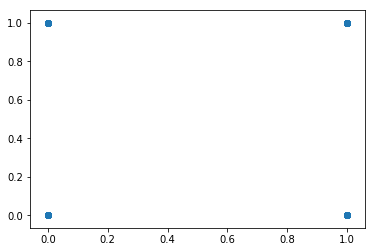

In [70]:
import matplotlib.pyplot as plt

plt.scatter(fre, y_train)
plt.show()


提出用

In [17]:
test = pd.read_csv('data_test.csv')

In [19]:
adv_id = test["advertiser_id"]
uid = test["uid"]
frequency = test["frequency"]
X_test = np.matrix(pd.concat([adv_id, uid,frequency], axis=1))

In [41]:
y_pred = clf.predict_proba(X_test)

array([[0.9, 0.1]])

In [42]:
y_pred = y_pred[:,0]

In [52]:
f = open('submit.dat', 'w') # 書き込みモードで開く
y_pred = list(map(str, y_pred))
for p in y_pred:
    f.writelines(p + "\n") # シーケンスが引数。
f.close()

In [58]:
def clickrate(ID_list, click_list):
    c = Counter(ID_list)
    
    clickrate = {}
    for ID, click in zip(ID_list, click_list):
        if(click == 1):
            if(not ID in clickrate.keys()):
                clickrate[ID] = 1
            else:
                clickrate[ID] += 1
            
        
    for ID, click in clickrate.items():
        clickrate[ID] = click/c[ID]
    
        
    return clickrate

In [62]:
clickrate(adv_id, click)

{1229: 0.08452908948604226,
 1235: 0.07537993920972644,
 1255: 0.15704387990762125,
 1264: 0.0737410071942446,
 1265: 0.0856269113149847,
 1268: 0.08231193073203644,
 1270: 0.11925507647432781,
 1278: 0.06051066806575726,
 1309: 0.1091307257132429,
 1312: 0.11900338760791171,
 1316: 0.09008664627930683,
 1349: 0.061452513966480445,
 1350: 0.11514975283512649,
 1354: 0.10960804717308359,
 1356: 0.06463089238067003,
 1357: 0.1405775075987842,
 1375: 0.10469667318982387,
 1383: 0.08968916883472546,
 1386: 0.10084033613445378,
 1403: 0.10187652675993782,
 1408: 0.10037934053107675,
 1409: 0.07751937984496124,
 1431: 0.1069199910853577,
 1436: 0.0791628753412193,
 1440: 0.0706713780918728,
 1445: 0.07244250970000947,
 1446: 0.04878048780487805,
 1461: 0.08719317527607683,
 1471: 0.11084964082239286,
 1472: 0.1047142261159783,
 1473: 0.09678510998307953,
 1480: 0.09436696250679225,
 1487: 0.0667016806722689,
 1489: 0.09070949849780448,
 1492: 0.09934771700953336,
 1513: 0.12956810631229235,


In [88]:
import hashlib
def hashing_vectorizer(ID_list, N):
    x = np.zeros(N, dtype = int)
    for ID in ID_list:
         h = hash(ID)
         x[ID % N] += 1
    
    return x

In [89]:
hashing_vectorizer(adv_id, 50)

array([  3439,   2585,   9809,  49372,  30836,  14437,  25496,   2941,
        15732, 270957,    125,  89321,  29544,   7437,  36130,  13955,
        47124,  63224,  41980,  70219, 134704,  35511,   7032,   8349,
       115113,   2044,      0,   1514,  30635,  22671, 173327,  54087,
          381,  62187,   7741,  60814,   7641,  87329,  17410,  23907,
         5920,   3148,  27982,    578,      0,  28834,   3073,   6261,
        18458,  45254])

In [81]:
hash(10000)

10000